# **Dog and Cat Classifcation w/ 5-Layer Model and VGG16 Model**

## **Import Database from Google Drive or Kaggle.** ##




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Data/dogs-cats-images.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

# !pip install opendatasets 
# import opendatasets as od
# od.download(
#      "https://www.kaggle.com/datasets/chetankv/dogs-cats-images")
 


Mounted at /content/drive


## **Import Necessary Packages**

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import random, os,shutil,cv2,imutils,math

## **Set the Path for Dataset and Create DataFrame and Arrays**

In [ ]:
# Set all Paths for Data
train_path = "dogs-cats-images/dataset/training_set"
test_path = "dogs-cats-images/dataset/test_set"


In [ ]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]

labels = ['dogs', 'cats']

#For Training 
dog_files = os.listdir(os.path.join(train_path, labels[0]))
dog_target = np.ones(len(dog_files),dtype=int)

cat_files = os.listdir(os.path.join(train_path, labels[1]))
cat_target =  np.zeros(len(cat_files),dtype=int)

dog_files = [os.path.join(os.path.join(train_path,labels[0]),f) for f in dog_files]
cat_files = [os.path.join(os.path.join(train_path,labels[1]),f) for f in cat_files]

print("Number of dog files:", len(dog_files))
print("Number of cat files:", len(cat_files))

X_train = np.concatenate((dog_files, cat_files))
Y_train = np.concatenate((dog_target, cat_target))
df_train = pd.DataFrame(
    {
        'img': X_train,
        'category': Y_train
    }
)
df_train.head(10)

#For Testing

dog_files = os.listdir(os.path.join(test_path, labels[0]))
dog_target = np.ones(len(dog_files),dtype=int)

cat_files = os.listdir(os.path.join(test_path, labels[1]))
cat_target =  np.zeros(len(cat_files),dtype=int)

dog_files = [os.path.join(os.path.join(test_path,labels[0]),f) for f in dog_files]
cat_files = [os.path.join(os.path.join(test_path,labels[1]),f) for f in cat_files]

print("Number of dog files:", len(dog_files))
print("Number of cat files:", len(cat_files))

X_test = np.concatenate((dog_files, cat_files))
Y_test = np.concatenate((dog_target, cat_target))
df_test = pd.DataFrame(
    {
        'img': X_test,
        'category': Y_test
    }
)
df_test.head(10)



Number of dog files: 4000
Number of cat files: 4000
Number of dog files: 1000
Number of cat files: 1000


,img,category
0,dogs-cats-images/dataset/test_set/dogs/dog.411...,1
1,dogs-cats-images/dataset/test_set/dogs/dog.454...,1
2,dogs-cats-images/dataset/test_set/dogs/dog.466...,1
3,dogs-cats-images/dataset/test_set/dogs/dog.421...,1
4,dogs-cats-images/dataset/test_set/dogs/dog.473...,1
5,dogs-cats-images/dataset/test_set/dogs/dog.403...,1
6,dogs-cats-images/dataset/test_set/dogs/dog.467...,1
7,dogs-cats-images/dataset/test_set/dogs/dog.420...,1
8,dogs-cats-images/dataset/test_set/dogs/dog.449...,1
9,dogs-cats-images/dataset/test_set/dogs/dog.418...,1


## **Specify the Image Width,Height,Channel,and Batch Size**

In [ ]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3
batch_size = 64


## **Test Generator on Image for Augmentation**

dogs-cats-images/dataset/training_set/cats/cat.3771.jpg


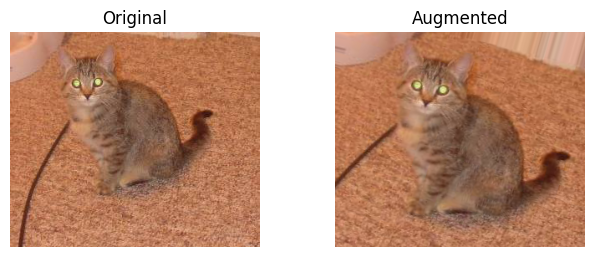

<Figure size 640x480 with 0 Axes>

In [ ]:
#Check Image Augmentation 

img = load_img(df_train.iloc[5320,0])
print(df_train.iloc[5320,0])
# Convert the image to a NumPy array
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# Create an ImageDataGenerator for data augmentation
example_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

# Generate 1 augmented image from df
aug_iter = example_datagen.flow(x, batch_size=1)
aug_img = aug_iter.next()[0]

plt.figure(figsize=(20,20))

plt.subplot(5,5,1)
plt.subplots_adjust(hspace=0.3,wspace = 0.3)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(5,5,2)
plt.subplots_adjust(hspace=0.3,wspace = 0.3)
plt.imshow(aug_img)
plt.title("Augmented")
plt.axis('off')

plt.show()

plt.savefig('drive/MyDrive/Pictures/AugmentedImage3.png')

## **Create Function for models VGG16 and 5-Layer CNN Model & Create Callback for Early Stop and Reduce Learning Rate**

In [ ]:
from matplotlib.colors import Image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,\
    Dropout, Flatten, Dense, Activation,\
    BatchNormalization,GlobalMaxPooling2D
from keras.applications.vgg16 import VGG16

from sklearn.neighbors import KNeighborsClassifier

def create_model_VGG16_R(dropout):
  # load model
  model = VGG16(include_top=False, input_shape=(Image_Width, Image_Height, Image_Channels))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(dropout)(dense1)
  output = Dense(1, activation='sigmoid')(dropout1)
  #define new model
  model = Model(inputs=model.inputs, outputs=output)
  return model

def create_model_CNN(dropout):
  model = Sequential()

  model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(dropout))

  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(dropout))

  model.add(Conv2D(128,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


## **Save model picture**

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

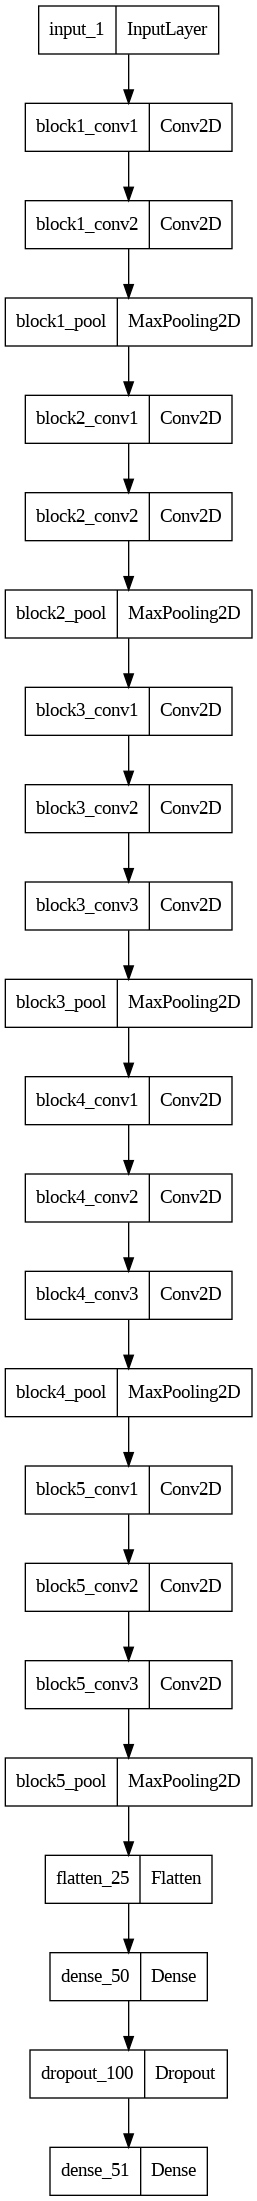

In [ ]:
#Save Model 
from keras.utils import plot_model
modelTest = create_model_VGG16_R(0.0)
modelTest2 = create_model_CNN(0.0)
modelTest.summary()
modelTest2.summary()
plot_model(modelTest, to_file='./drive/MyDrive/Pictures/modelVGG16.png')
plot_model(modelTest2, to_file='./drive/MyDrive/Pictures/modelCNN.png')

## **KNN Model**

### **Pre-Process Data**

#### **Create Functions to return extract color array and raw pixel array**

In [ ]:
def extract_color_histogram(image, bins=(8, 8, 8)):
  #Remove Brightness from color
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])
	if imutils.is_cv2():
		hist = cv2.normalize(hist)
	else:
		cv2.normalize(hist, hist)
	return hist.flatten()
 
def create_KNN(test_path):
  rawImages = []
  features = []
  for path in test_path:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    pixels = cv2.resize(img, Image_Size).flatten()
    hist = extract_color_histogram(img)
    rawImages.append(pixels)
    features.append(hist)
  return rawImages, features

#### **Runs the Function to get the extract color array and raw pixel array**

In [ ]:
#Get the images from the file paths and 
#rawImages is the pixel and features is the extract color
rawImages, features = create_KNN(X_train)
rawImages_test, features_test = create_KNN(X_test)


### **Running the KNN Model**

#### **Create Function for KNN to run on**

In [ ]:
def findBestK(x_train, label):
  cv_scores = []
  k_values = list(range(1,150,10))
  for k in k_values:
    print("=====================")
    print("====== K  => %d ======" % k)
    print("=====================")
    #create a new KNN model
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    #train model with cv of 5 
    cv_score = cross_val_score(knn_cv, x_train, label, cv=5)
    cv_scores.append(cv_score.mean())
    print("[INFO]CV Mean Value=",cv_score.mean())
  # plot the cross-validation scores for each k
  plt.plot(k_values, cv_scores)
  plt.xlabel('Value of k for KNN')
  plt.ylabel('Cross-validated Accuracy')
  plt.show()
  best_k = k_values[np.argmax(cv_scores)]
  return best_k
def KNN():
  #Change the KNN for rawImage or feature dataset
  x_trainKNN = rawImages
  x_testKNN = rawImages_test
  #best_k = findBestK(x_trainKNN, Y_train) 
  best_k = 89
  final_knn = KNeighborsClassifier(n_neighbors=best_k)
  final_knn.fit(x_trainKNN, Y_train)

  # Evaluate final model on validation set
  accuracy = final_knn.score(x_testKNN, Y_test)
  print("k value: {}".format(best_k))
  print("Validation accuracy: {:.2f}%".format(accuracy * 100))

#### **Run KNN Model**

In [ ]:
KNN()

## **CNN Model**

### **Create VGG16 Model**

In [ ]:
from sklearn.model_selection import StratifiedKFold

#This is training under 5-folds and training with 20 epoch. We are going to run 5 iterations with different drop out values
def trainVGG16(pathStored):
  fold_accs = [] # List to store accuracies for each fold
  histories = [] # List to store history for each fold
  num_folds = 5
  epochs = 20
  dropout = [0]
  for dropout_value in dropout:
    # Create a StratifiedKFold object to split the data
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X_train,Y_train)):
      print("=========================================")
      print("====== K Fold Validation Fold => %d ======" % fold)
      print("=========================================")
      #Spilt the data into training and validation for this fold
      x_tr, y_tr = X_train[train_index], Y_train[train_index]
      x_val, y_val = X_train[val_index], Y_train[val_index]
      #Change 0 and 1 to String Name
      df_train["category"] = df_train["category"].replace({0:'cat',1:'dog'})
      #Generate Batches of Augmented Images for Training 
      train_datagen = ImageDataGenerator(rotation_range=15,
                                        rescale=1./255,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        )
      train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train.iloc[train_index],
        x_col="img",
        y_col="category",
        target_size=Image_Size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True
      )
      validation_datagen = ImageDataGenerator(rescale=1./255)
      validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_train.iloc[val_index],
        x_col="img",
        y_col="category",
        target_size=Image_Size,
        batch_size=batch_size,
        class_mode="binary",
      ) 
      validation_size = validation_generator.n
      train_size = train_generator.n
      #initialize Model
      model = create_model_VGG16_R(dropout_value)
      #Compile Model 
      model.compile(loss='binary_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
      #Fit Model with CNN
      history = model.fit(
          train_generator,
          epochs=epochs,
          validation_steps=validation_size/batch_size,
          validation_data=validation_generator,
          steps_per_epoch=train_size/batch_size,
          callbacks=callbacks
      )
      #Append the history object to the list
      histories.append(history)
      #Evaluate the model on the validation data for this fold
      scores = model.evaluate(validation_generator, verbose=0)
      fold_accs.append(scores[1])
      print("Validation Accuracy: %.2f%%" % (scores[1]*100))
      # Save the model weights for this fold
      directory = os.path.join(pathStored,"Dropout-"+str(dropout_value))
      if not os.path.exists(directory):
        os.makedirs(directory)
      model.save_weights(os.path.join(directory,f'model_weights_fold_{fold}.h5'))
      # Save the history for this fold as well
      for history in histories:
        history_dict = history.history
        history_df = pd.DataFrame(history_dict)
        history_df.to_csv(os.path.join(directory,f'history_{fold}.csv'), index=False)
  return histories,fold_accs

### **Train VGG16 Model**

In [ ]:
trainVGG16("drive/MyDrive/Models/VGG16_R-20Epoch")

### **Create 5-Layer CNN Model**

In [ ]:
def trainCNN(pathStored):
  fold_accs = [] # List to store accuracies for each fold
  histories = [] # List to store history for each fold
  num_folds = 5
  epochs = 20
  dropout = [0.4]
  for dropout_value in dropout:
    # Create a StratifiedKFold object to split the data
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X_train,Y_train)):
      print("=========================================")
      print("====== K Fold Validation Fold => %d ======" % fold)
      print("=========================================")
      #Spilt the data into training and validation for this fold
      x_tr, y_tr = X_train[train_index], Y_train[train_index]
      x_val, y_val = X_train[val_index], Y_train[val_index]
      #Change 0 and 1 to String Name
      df_train["category"] = df_train["category"].replace({0:'cat',1:'dog'})
      #Generate Batches of Augmented Images for Training 
      train_datagen = ImageDataGenerator(rotation_range=15,
                                        rescale=1./255,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        )
      train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train.iloc[train_index],
        x_col="img",
        y_col="category",
        target_size=Image_Size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True
      )
      validation_datagen = ImageDataGenerator(rescale=1./255)
      validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_train.iloc[val_index],
        x_col="img",
        y_col="category",
        target_size=Image_Size,
        batch_size=batch_size,
        class_mode="binary",
      ) 
      validation_size = validation_generator.n
      train_size = train_generator.n
      #initialize Model
      model = create_model_CNN(dropout_value)
      #Compile Model 
      model.compile(loss='binary_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
      #Fit Model with CNN
      history = model.fit(
          train_generator,
          epochs=epochs,
          validation_steps=validation_size/batch_size,
          validation_data=validation_generator,
          steps_per_epoch=train_size/batch_size,
          callbacks=callbacks
      )
      #Append the history object to the list
      histories.append(history)
      #Evaluate the model on the validation data for this fold
      scores = model.evaluate(validation_generator, verbose=0)
      fold_accs.append(scores[1])
      print("Validation Accuracy: %.2f%%" % (scores[1]*100))
      # Save the model weights for this fold
      directory = os.path.join(pathStored,"Dropout-"+str(dropout_value))
      if not os.path.exists(directory):
        os.makedirs(directory)
      model.save_weights(os.path.join(directory,f'model_weights_fold_{fold}.h5'))
      # Save the history for this fold as well
      for history in histories:
        history_dict = history.history
        history_df = pd.DataFrame(history_dict)
        history_df.to_csv(os.path.join(directory,f'history_{fold}.csv'), index=False)
  return histories,fold_accs

### **Train 5-Layer CNN Model**

In [ ]:
trainCNN("drive/MyDrive/Models/CNN-20Epoch")

====== K Fold Validation Fold => 0 ======
Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Epoch 1/20
  9/100 [=>............................] - ETA: 6:09 - loss: 1.3187 - accuracy: 0.5434

KeyboardInterrupt: ignored

## **Evaluate Both CNN Model on Testing Set**

### **Create Function to Evaluate Both Models**

In [ ]:
import csv
#Find the best valdiation accuracy for each dropout and fold
def evauluteVGG16_R():
  test_data_generator = ImageDataGenerator(rescale=1./255)
  test_generator = test_data_generator.flow_from_directory(
      test_path,
      target_size=Image_Size,
      batch_size=batch_size,
      class_mode='binary',
      shuffle=False)
  #Retrive the models from the Drive
  pathToModel="./drive/MyDrive/Models/VGG16_R-20Epoch"
  folders = os.listdir(pathToModel)
  for f in folders:
    if(f.startswith("Dropout")):
      pathToDropout=os.path.join(pathToModel,f)
      test_results = []
      print("Dropout Name: " + f)
      for file in os.listdir(pathToDropout):
        if(file.startswith("model_weights")):
          print("   On Model: " + file)
          #Get the number in the folder name
          dropout_number = f.split("-")[1]
          #Load the Model
          model = create_model_VGG16_R(dropout_number)

          #Load the save Weights
          model.load_weights(os.path.join(pathToDropout,file))

          #Compile Model
          model.compile(loss='binary_crossentropy',
                        optimizer='adam', metrics=['accuracy'])
          
          # Evaluate the model on a test set
          score = model.evaluate(test_generator)
          print("   " + file + ": " + str(score))
          test_results.append((file,score[0],score[1]))
      with open(os.path.join(pathToDropout,f + "-testscore.csv"), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write a header row
        writer.writerow(['Model Name', 'Loss', 'Accuracy'])
        
        # Write each tuple as a row in the CSV file
        for row in test_results:
            writer.writerow(row)
#Find the best valdiation accuracy for each dropout and fold
def evauluteCNN():
  test_data_generator = ImageDataGenerator(rescale=1./255)
  test_generator = test_data_generator.flow_from_directory(
      test_path,
      target_size=Image_Size,
      batch_size=batch_size,
      class_mode='binary',
      shuffle=False)
  #Retrive the models from the Drive
  pathToModel="./drive/MyDrive/Models/CNN-20Epoch"
  folders = os.listdir(pathToModel)
  for f in folders:
    if(f.startswith("Dropout")):
      pathToDropout=os.path.join(pathToModel,f)
      test_results = []
      print("Dropout Name: " + f)
      for file in os.listdir(pathToDropout):
        if(file.startswith("model_weights")):
          print("   On Model: " + file)
          #Get the number in the folder name
          dropout_number = f.split("-")[1]
          #Load the Model
          model = create_model_CNN(dropout_number)

          #Load the save Weights
          model.load_weights(os.path.join(pathToDropout,file))

          #Compile Model
          model.compile(loss='binary_crossentropy',
                        optimizer='adam', metrics=['accuracy'])
          
          # Evaluate the model on a test set
          score = model.evaluate(test_generator)
          print("   " + file + ": " + str(score))
          test_results.append((file,score[0],score[1]))
      with open(os.path.join(pathToDropout,f + "-testscore.csv"), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write a header row
        writer.writerow(['Model Name', 'Loss', 'Accuracy'])
        
        # Write each tuple as a row in the CSV file
        for row in test_results:
            writer.writerow(row)

### **Run the Function to Evaluate and Save the Scores in Folders**

In [ ]:
evauluteVGG16_R()
evauluteCNN()

Found 2000 images belonging to 2 classes.
Dropout Name: Dropout-0.2
   On Model: model_weights_fold_0.h5
32/32 [==============================] - 34s 1s/step - loss: 0.4587 - accuracy: 0.8270
   model_weights_fold_0.h5: [0.4586692452430725, 0.8270000219345093]
   On Model: model_weights_fold_1.h5
32/32 [==============================] - 37s 1s/step - loss: 0.3431 - accuracy: 0.8650
   model_weights_fold_1.h5: [0.3431379795074463, 0.8650000095367432]
   On Model: model_weights_fold_2.h5
32/32 [==============================] - 36s 1s/step - loss: 0.5553 - accuracy: 0.7965
   model_weights_fold_2.h5: [0.5553110837936401, 0.796500027179718]
   On Model: model_weights_fold_3.h5
32/32 [==============================] - 34s 1s/step - loss: 0.3984 - accuracy: 0.8495
   model_weights_fold_3.h5: [0.3984287977218628, 0.8495000004768372]
   On Model: model_weights_fold_4.h5
32/32 [==============================] - 33s 1s/step - loss: 0.4346 - accuracy: 0.8185
   model_weights_fold_4.h5: [0.434636

KeyboardInterrupt: ignored

### **Print the Score for each Dropout**

In [ ]:

def scoreOnModel(path):
  #Get the Average Score for each Dropout in VGG16_R
  pathToModel= path
  folders = os.listdir(pathToModel)
  average_score = []
  for f in folders:
    if(f.startswith("Dropout")):
      pathToDropout=os.path.join(pathToModel,f)
      for file in os.listdir(pathToDropout):
        if(file.startswith("Dropout-")):
          df = pd.read_csv(os.path.join(pathToDropout,file))
          print(f)
          print(df)
          print("Loss" + ": "+ str(df['Loss'].mean() * 100) + "%")
          print("Average" + ": "+ str(df['Accuracy'].mean() * 100) + "%")
          average_score.append(df['Accuracy'].mean())
  print(average_score)   

scoreOnModel("./drive/MyDrive/Models/VGG16_R-20Epoch")
print("CNN")
scoreOnModel("./drive/MyDrive/Models/CNN-20Epoch")

##**Open the history from training to see Accuracy vs Epoch and Lost vs Epoch graph**

### **Define the Function for plotHistory**

In [ ]:
#Plot the history for each dropout
def plotHistory(path, savePath):
  #Retrive the models from the Drive
  pathToModel=path
  folders = os.listdir(pathToModel)
  for f in folders:
    if(f.startswith("Dropout")):
      pathToDropout=os.path.join(pathToModel,f)
      histories=[]
      for file in os.listdir(pathToDropout):
        if(file.startswith("history")):
          df = pd.read_csv(os.path.join(pathToDropout,file))
          histories.append(df)
      for i in range(len(histories)):
          fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
          fig.suptitle(f"{f} - Fold {i}")
          axs[0].plot(histories[i]['loss'])
          axs[0].plot(histories[i]['val_loss'])
          axs[0].set_title('Epoch vs Loss',fontsize=10)
          axs[0].set_ylabel('loss')
          axs[0].set_xlabel('epoch')
          axs[0].legend(['Train', 'Val'], loc='upper left')
          
          axs[1].plot(histories[i]['accuracy'])
          axs[1].plot(histories[i]['val_accuracy'])
          axs[1].set_title('Epoch vs Accuracy',fontsize=10)
          axs[1].set_ylabel('accuracy')
          axs[1].set_xlabel('epoch')
          axs[1].legend(['Train', 'Val'], loc='upper left')
          plt.show()
          saveDir=savePath + f
          if not os.path.exists(saveDir):
            os.makedirs(saveDir)
          fig.savefig(f"{saveDir}/VGGFold-{i}.png")
          
          

### **Run the Function for plotHistory**

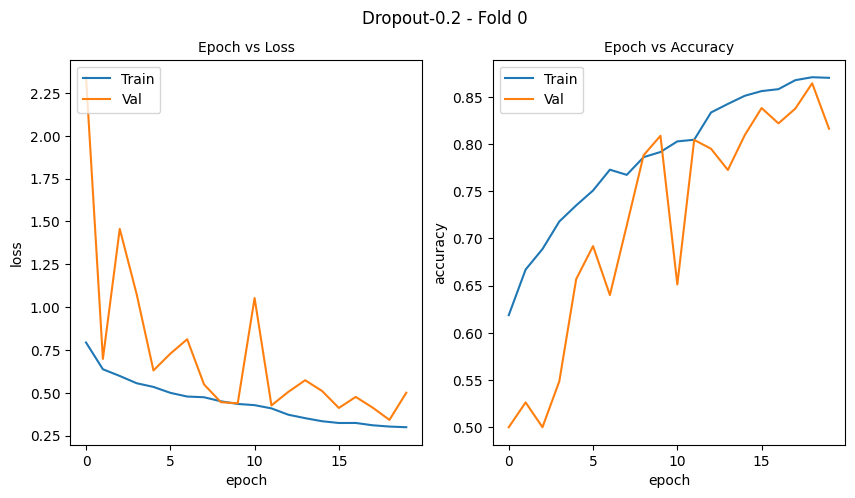

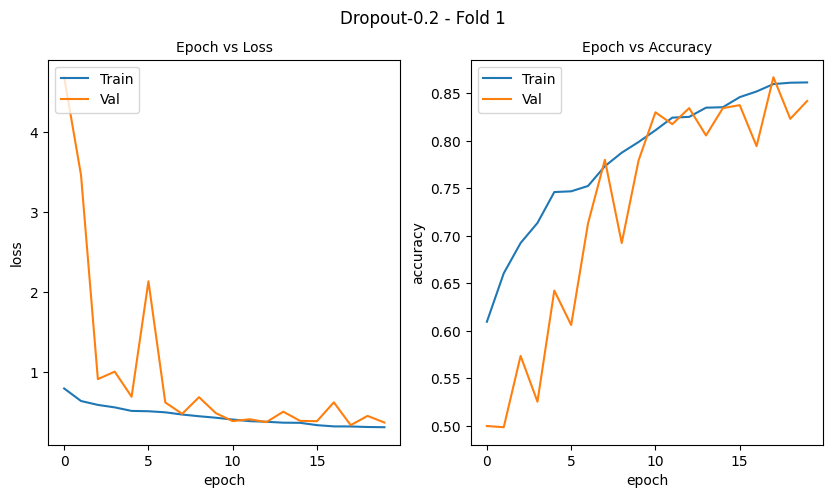

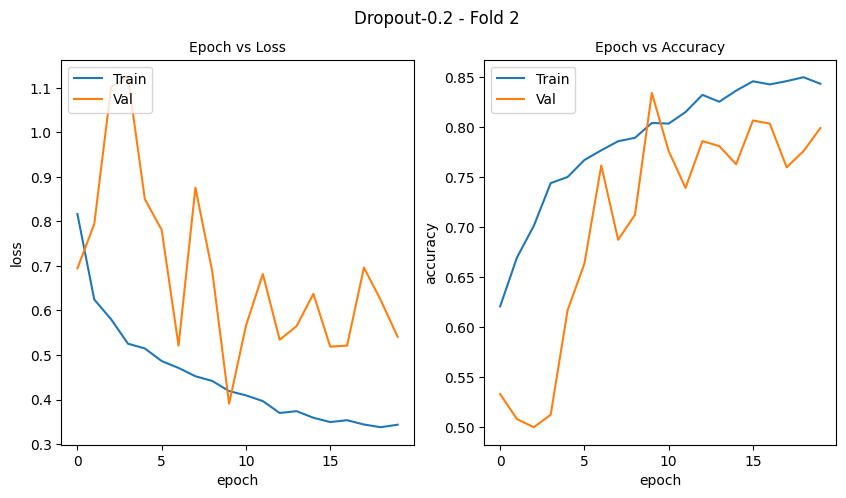

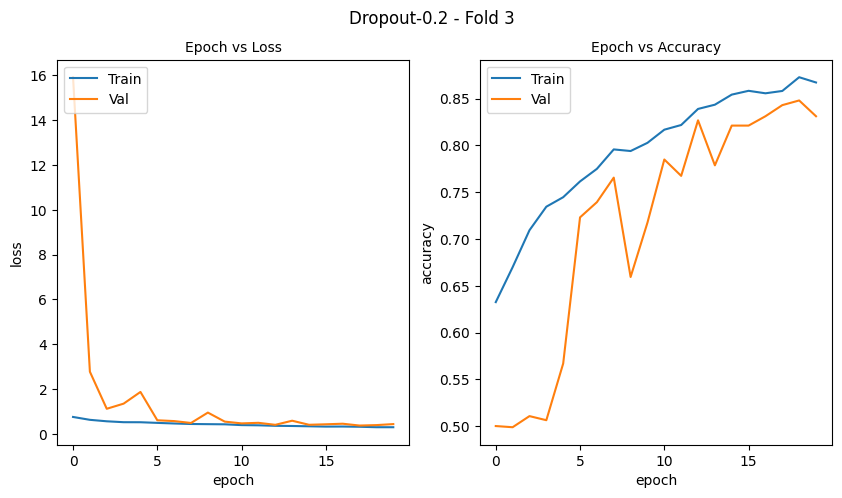

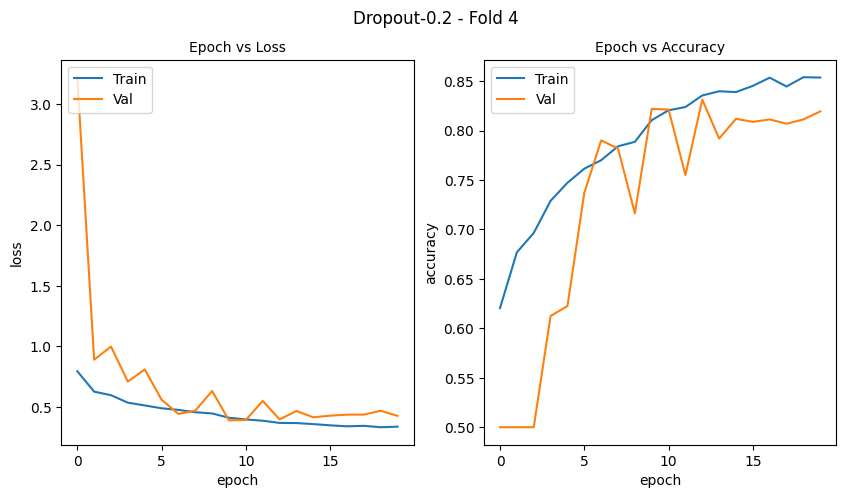

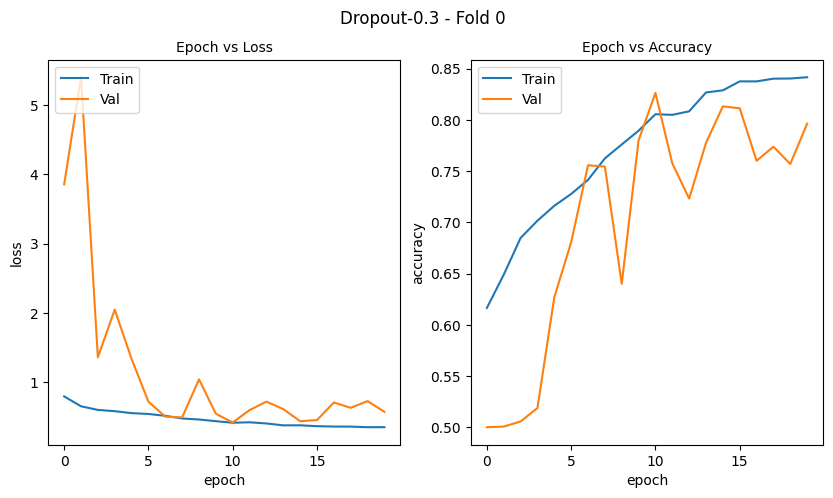

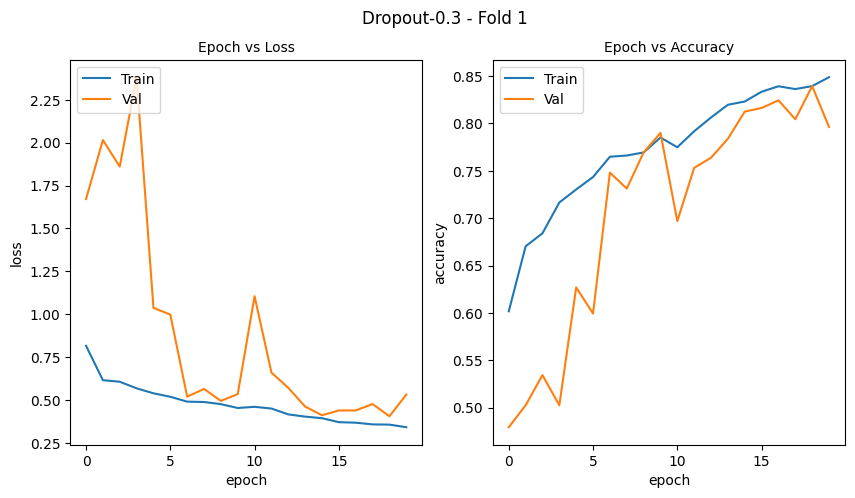

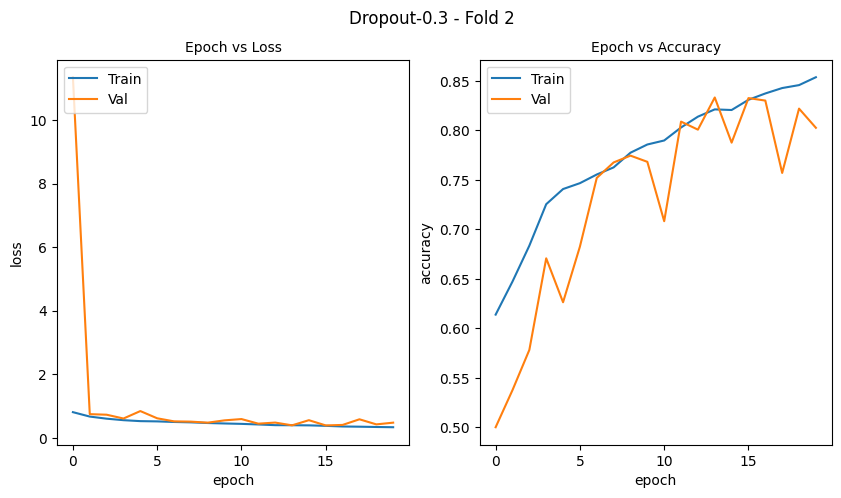

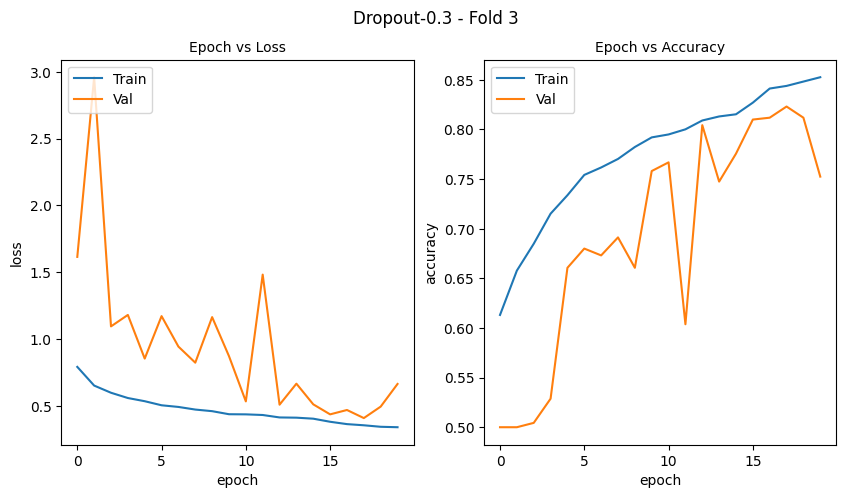

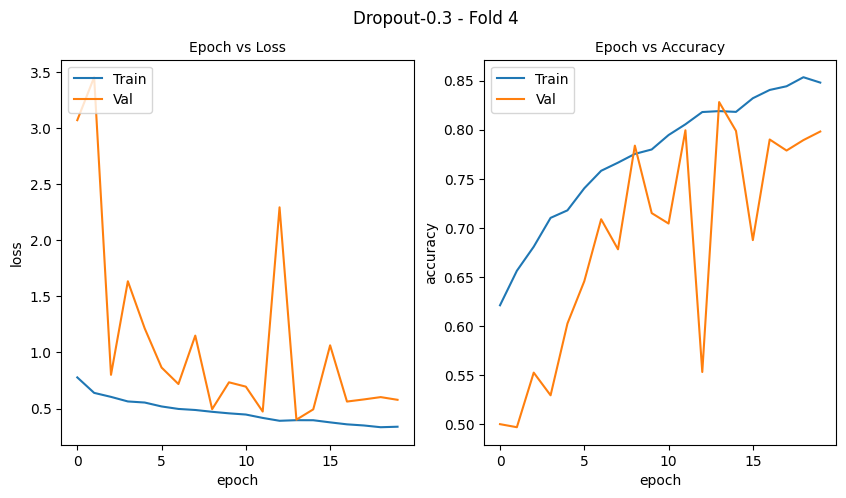

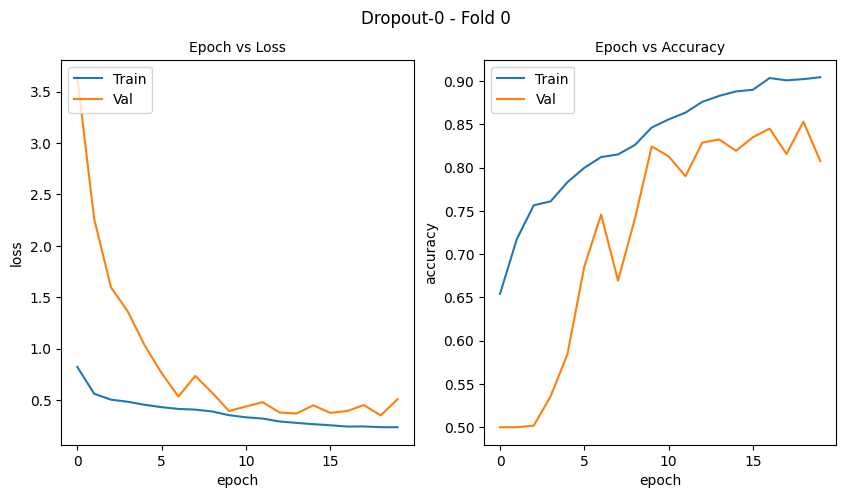

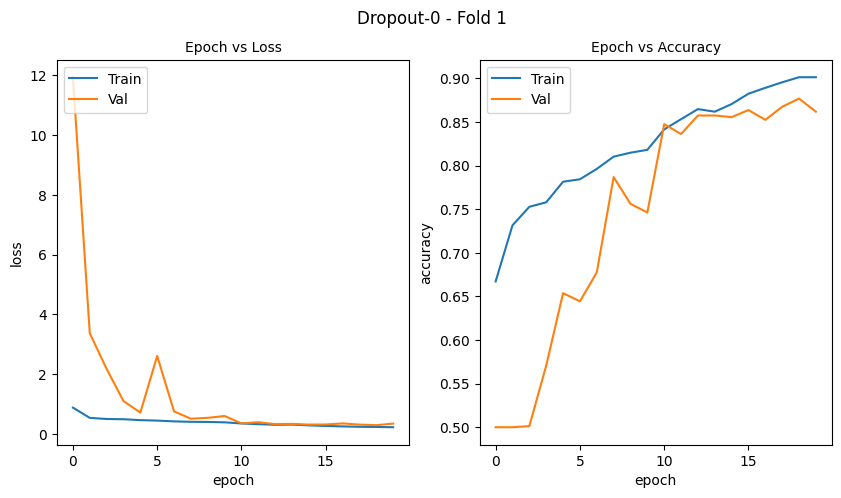

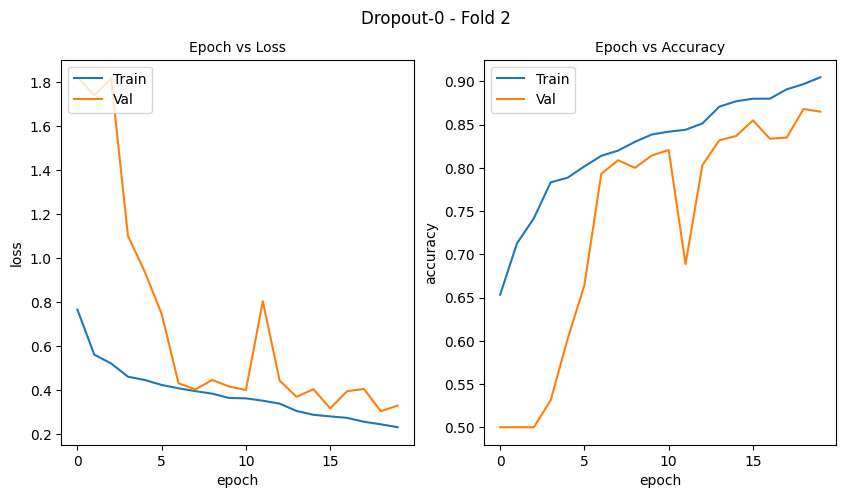

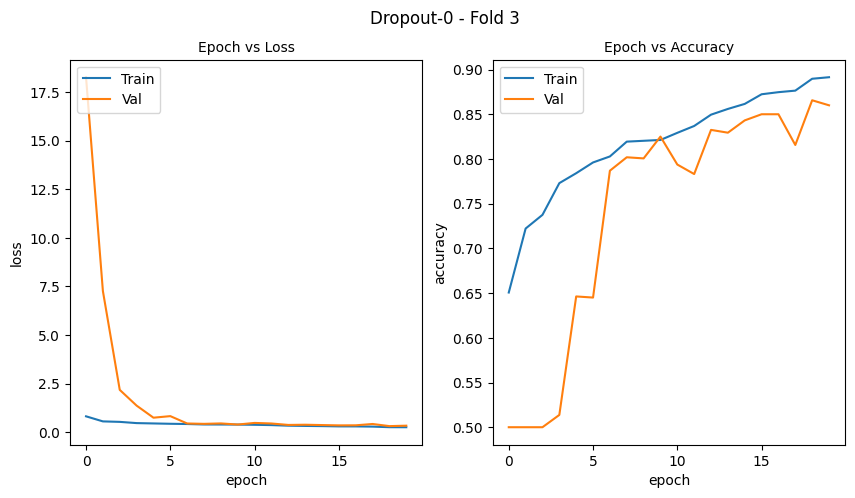

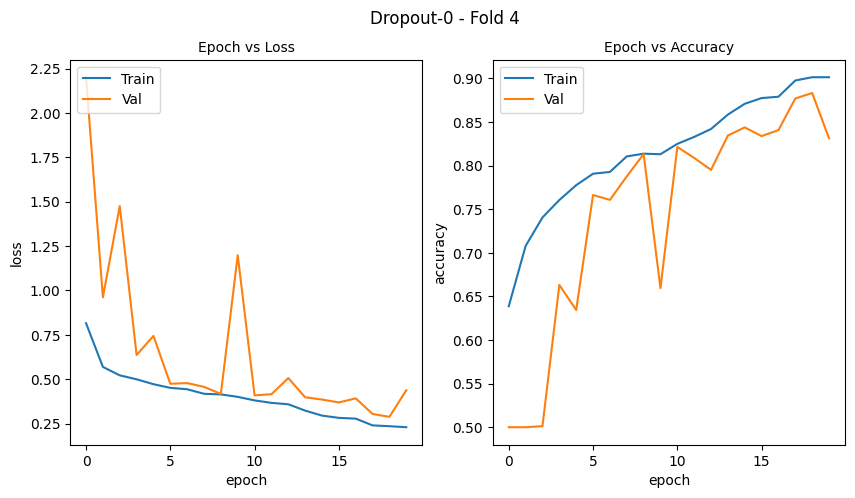

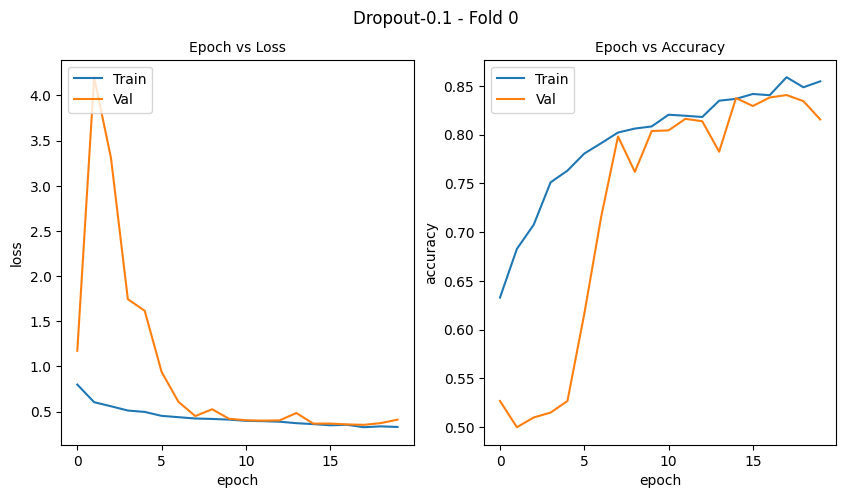

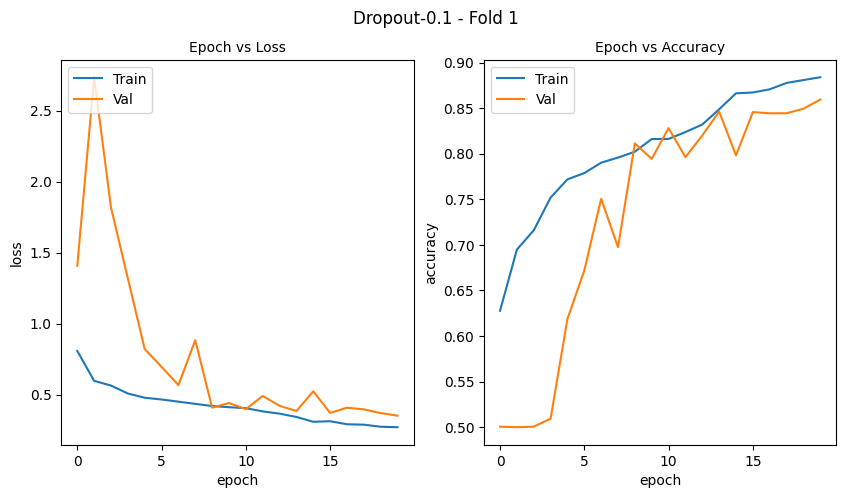

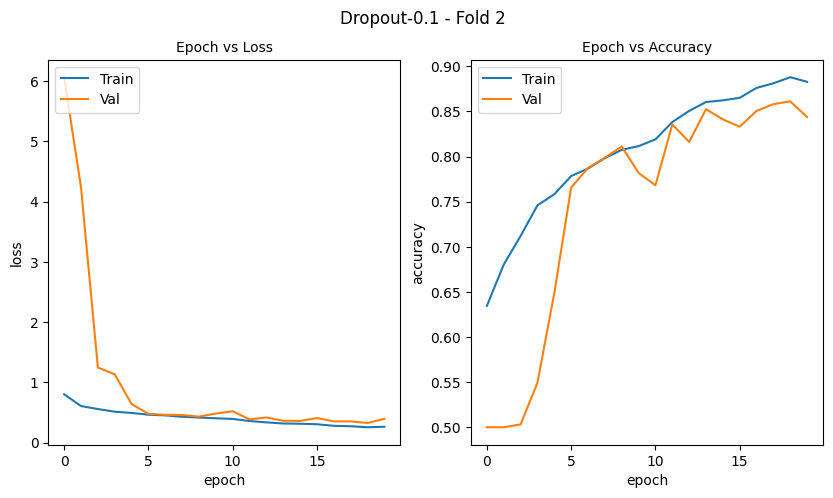

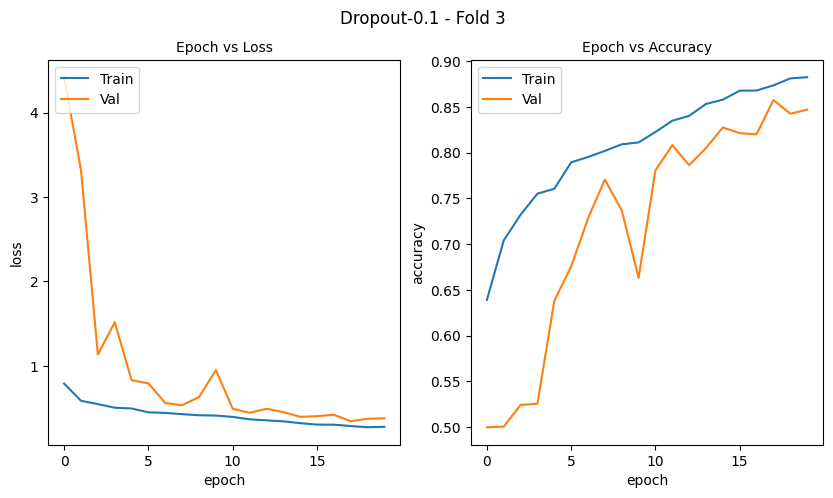

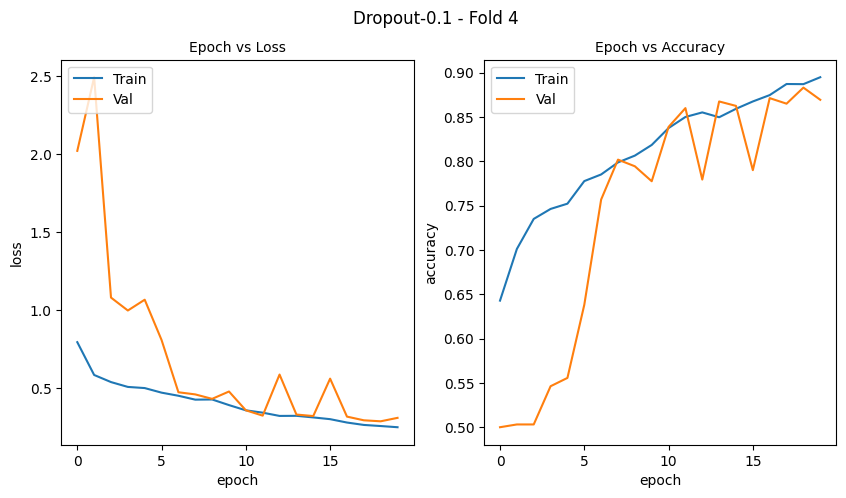

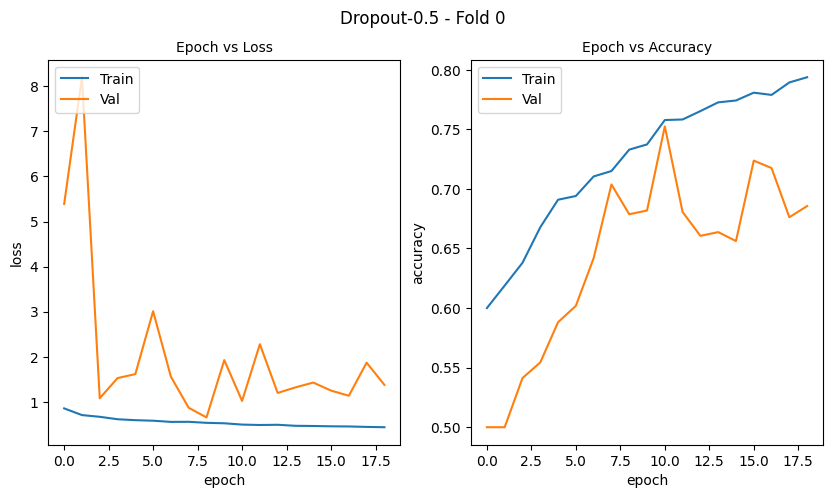

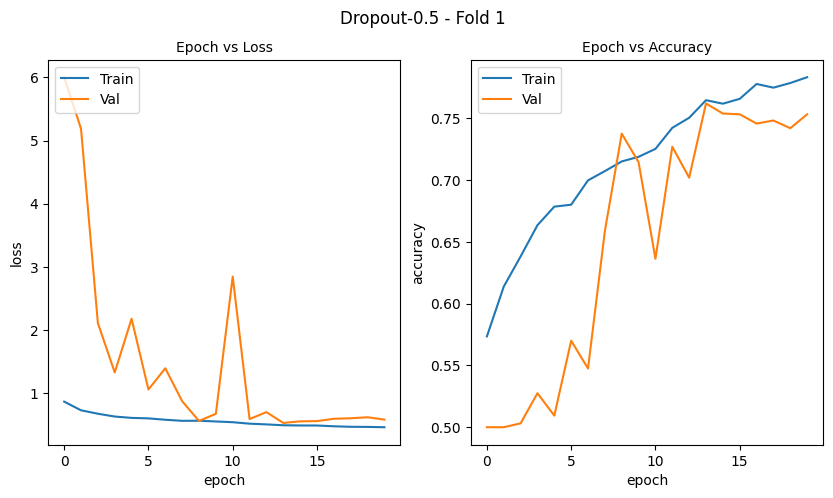

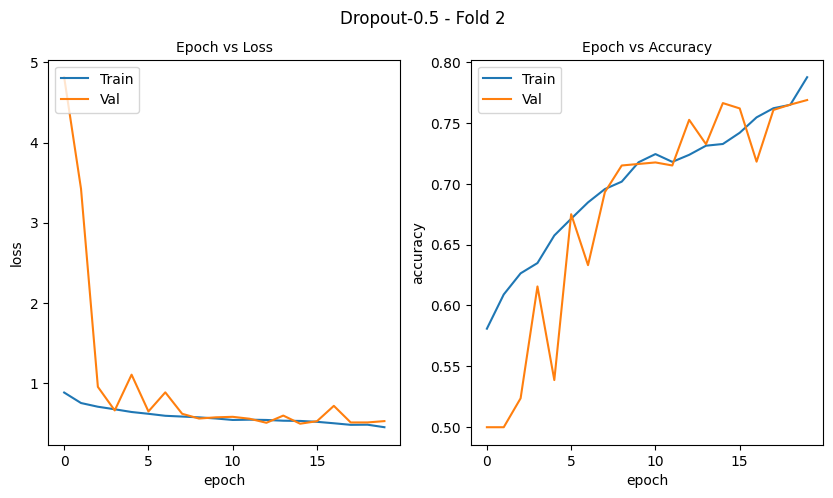

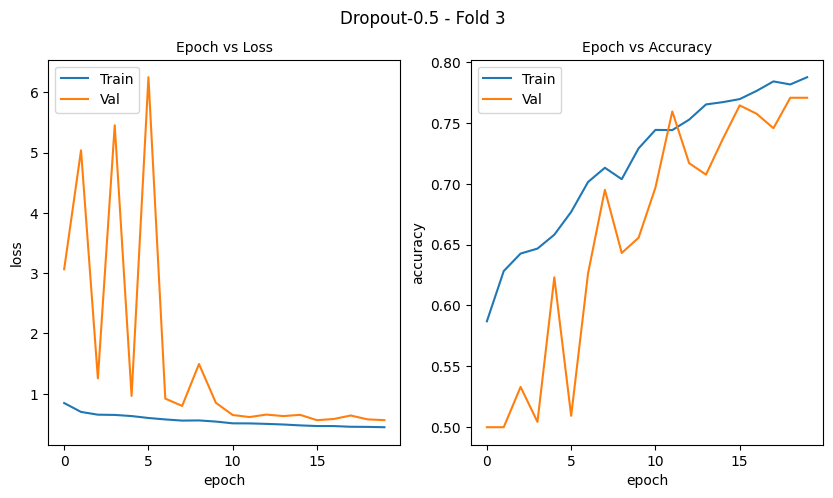

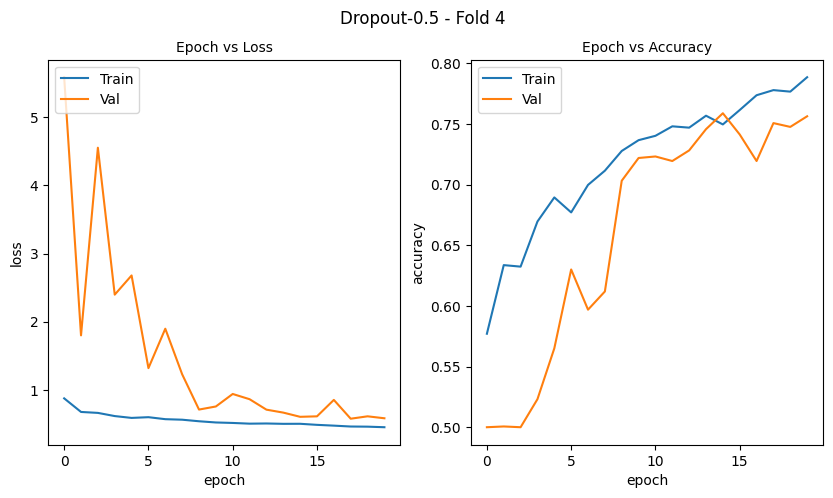

In [ ]:
plotHistory("./drive/MyDrive/Models/VGG16_R-20Epoch","/content/drive/MyDrive/Pictures/modelVGG16/")
plotHistory("./drive/MyDrive/Models/CNN-20Epoch","/content/drive/MyDrive/Pictures/modelCNN/")

## **Predict Images from model**

### **Create Model Array and Image Paths and Class Labels**

In [ ]:
#Image Path is from the test set
images_path = ["/content/dogs-cats-images/dataset/test_set/cats/cat.4001.jpg",
               "/content/dogs-cats-images/dataset/test_set/dogs/dog.4043.jpg",
               "/content/dogs-cats-images/dataset/test_set/dogs/dog.4099.jpg",
               "/content/dogs-cats-images/dataset/test_set/cats/cat.4067.jpg",   
               ]
#Remember that model 4 in Dropout 3 is the best model
pathToModel="/content/drive/MyDrive/Models"
models = [[create_model_VGG16_R(0.3),os.path.join(pathToModel,"VGG16_R-20Epoch/Dropout-0.3/model_weights_fold_4.h5"),"VGG16-Dropout-0.3"],
          [create_model_VGG16_R(0.0),os.path.join(pathToModel,"VGG16_R-20Epoch/Dropout-0.0/model_weights_fold_4.h5"),"VGG16-Dropout-0"],
          [create_model_CNN(0.0),os.path.join(pathToModel,"CNN-20Epoch/Dropout-0.0/model_weights_fold_1.h5"),"CNN-Dropout-0"]
          ]
class_labels = ['cat', 'dog']


### **Plot the Image and the confidence score**

1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 169ms/step


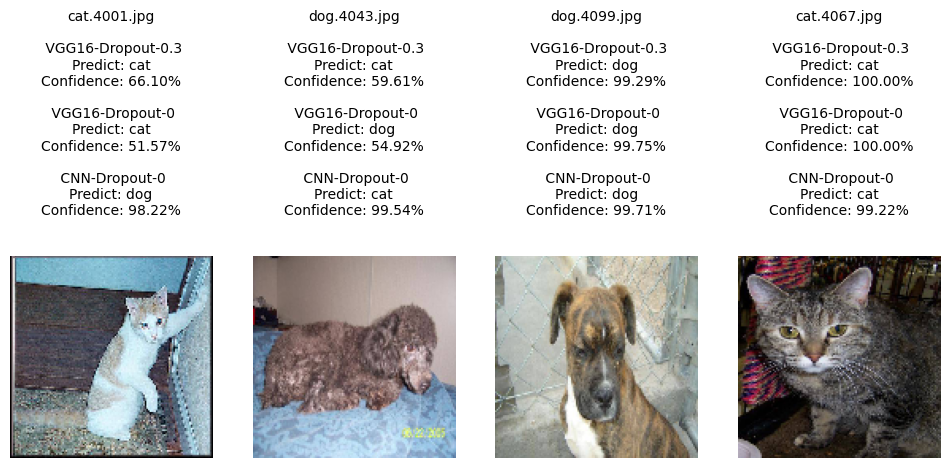

In [ ]:
#This is array that holds the predictions of each model for each image 
predictImgVal=[]

fig, axes = plt.subplots(ncols=4, figsize=(12, 4))
axes = axes.ravel()

for i,img_p in enumerate(images_path):
  predictions = []
  img = load_img(img_p, target_size=Image_Size)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  axes[i].imshow(img)
  axes[i].axis('off')
  title = os.path.basename(img_p) + "\n\n"
  for model in models:
    model[0].load_weights(model[1])
    model[0].compile(loss='binary_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
    
    prediction = model[0].predict(img_array)
    predictions.append(prediction[0][0])

    #Get the predicted class as either cat or dog
    predicted_class = class_labels[round(prediction[0][0])]

    # Get the confidence score as the highest class probability
    confidence_score = prediction[0][0] if predicted_class == 'dog' else 1 - prediction[0][0]

    confidence_score *= 100

    confidence_score_str = "%.2f%%" % confidence_score
    # Set the title for the subplot
    title += f" {model[2]}\nPredict: {predicted_class}\nConfidence: {confidence_score_str}\n\n"
  predictImgVal.append(predictions)
  axes[i].set_title(title,fontsize=10)
plt.show()
plt.savefig("Picture.png")

## **GradCam & GradCam++ & Saliency Map**

### **Make sure tf-keras-vis is Installed in System**

In [ ]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.3 MB/s eta 0:00:00


### **Define GradCam Function(includes GradCamPlusPlus in parameters)**

In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import BinaryScore
from matplotlib import cm

def GradCam(models,images_path,penultimate_layer_val=-1, isGradCamPlus=False):
  for j, model in enumerate(models): 
    #Load the weights of the model and compile it
    model[0].load_weights(model[1])
    model[0].compile(loss='binary_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
    
    f, ax = plt.subplots(nrows=1, ncols=len(images_path), figsize=(12, 4))

    #Create the GradCam object or GradCam++
    if(isGradCamPlus):
       f.suptitle("GradCam++")
       gradcam = GradcamPlusPlus(model[0], clone=True)
    else:
      f.suptitle("GradCam")
      gradcam = Gradcam(model[0], clone=True)
    for i, img_p in enumerate(images_path):

      #Pre-Process the Image
      img = load_img(img_p, target_size=Image_Size)
      img_array = img_to_array(img)
      img_array = np.expand_dims(img_array, axis=0)
      img_array /= 255.0

      #GradCam Implementation
      score = BinaryScore(round(predictImgVal[i][j]))
      cam = gradcam(score,
                img_array,
                penultimate_layer=penultimate_layer_val)
      heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

      predicted_class = class_labels[round(predictImgVal[i][j])]

      # Get the confidence score as the highest class probability
      confidence_score = predictImgVal[i][j] if predicted_class == 'dog' else 1 - predictImgVal[i][j]

      confidence_score *= 100

      confidence_score_str = "%.2f%%" % confidence_score
      
      title = f'{os.path.basename(img_p)}\n{model[2]} \n Predict: {predicted_class}\n Confidence: {confidence_score_str}'
      ax[i].set_title(title, fontsize=10)
      ax[i].imshow(img)
      ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
      ax[i].axis('off')

  plt.show()


### **Define Saliency Map Function**

In [ ]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
def saliency(models,images_path, number_of_iter=20, noise_spread_lvl=0.20):
  for j, model in enumerate(models): 
    #Load the weights of the model and compile it
    model[0].load_weights(model[1])
    model[0].compile(loss='binary_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
    
    f, ax = plt.subplots(nrows=1, ncols=len(images_path), figsize=(12, 4))

    #When the softmax activation function is applied to the last layer of model, 
    #it may obstruct generating the attention images
    replace2linear = ReplaceToLinear()
    f.suptitle("Saliency")
    #Create the Saliency object 
    saliency = Saliency(model[0],
                    model_modifier=replace2linear,
                    clone=True)
    for i, img_p in enumerate(images_path):

      #Pre-Process the Image
      img = load_img(img_p, target_size=Image_Size)
      img_array = img_to_array(img)
      img_array = np.expand_dims(img_array, axis=0)
      img_array /= 255.0

      score = BinaryScore(round(predictImgVal[i][j]))
      # Generate saliency map
      saliency_map = saliency(score, img_array,smooth_samples=number_of_iter,
                        smooth_noise=noise_spread_lvl)

      predicted_class = class_labels[round(predictImgVal[i][j])]

      # Get the confidence score as the highest class probability
      confidence_score = predictImgVal[i][j] if predicted_class == 'dog' else 1 - predictImgVal[i][j]

      confidence_score *= 100

      confidence_score_str = "%.2f%%" % confidence_score
      
      title = f'{os.path.basename(img_p)}\n{model[2]} \n Predict: {predicted_class}\n Confidence: {confidence_score_str}'
      ax[i].set_title(title, fontsize=10)
      ax[i].imshow(saliency_map[0], cmap='jet')
      ax[i].axis('off')
  plt.show()

### **Plot the GradCam, GradCam++, and Saliency Map using the Function with predefined models and images_path given eariler**

In [ ]:
selectOneModel = [models[0]]

GradCam(models, images_path, -1,True)
GradCam(models, images_path, -1,False)

saliency(models,images_path,20,0.2)

Output hidden; open in https://colab.research.google.com to view.